In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=15000):
  # 데이터 전처리(가공)후에 다시 train, test 데이터로 나눠주기 위해 원래 train_data의 크기를 기억
  len_train = len(train_data)
  
  all_data = pd.concat([train_data, test_data], axis=0, ignore_index = True)
  # 중복치와 결측치 제거
  all_data = all_data.drop_duplicates('document', keep='first')
  all_data = all_data.dropna(axis=0)
  
  # 후기 문장들을 sentence_list에 list로 저장
  sentence_list = list(all_data['document'])
  # 형태소로 나눈 문장들을 리스트에 따로 저장
  token_list = []
  for sentence in sentence_list:
    tokenize_sentence = tokenizer.morphs(sentence)
    tokenize_sentence = [word for word in tokenize_sentence if word not in stopwords] # 불용어 제거
    token_list.append(tokenize_sentence)
  # 토큰화한 문장들을 train, test로 나눠줌
  x_train = token_list[:len_train]
  x_test = token_list[len_train:]
  
  words = np.concatenate(x_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(15000 - 4) # <pad>, <bos>, <unk>, <unused> 토큰을 추가해야하기 때문에 4개를 빼줌
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
  
  word2index = {word : index for index, word in enumerate(vocab)} # 단어를 정수 인덱스로 바꿔줌
  
  def wordlist_to_indexlist(wordlist):
    return [word2index[word] if word in word2index else word2index['<UNK>'] for word in wordlist]
  
  x_train_index = list(map(wordlist_to_indexlist, x_train))
  x_test_index = list(map(wordlist_to_indexlist, x_test))
  
  return x_train_index, np.array(list(all_data['label'][:len_train])), x_test_index, np.array(list(all_data['label'][len_train:])), word2index, x_train, x_test
  
x_train, y_train, x_test, y_test, word2index, x_train_word, x_test_word = load_data(train_data, test_data)
index2word = {index : word for word, index in word2index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [11]:
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2 * 표준편차) 로 한다면 남는 문장의 비율은?
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  16.0182376132783
문장길이 최대 :  116
문장길이 표준편차 :  12.842655296434431
pad_sequences maxlen :  41
전체 문장의 0.9340557100486782%가 maxlen 설정값 이내에 포함됩니다. 


In [12]:
import tensorflow as tf

# 문장의 마지막 입력이 최종 state에 영향을 가장 크게 미치기 때문에 패딩 적용은 pre(앞쪽)으로 해줍니다.
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word2index['<PAD>'],
                                                        padding = 'pre',
                                                        maxlen = maxlen)
 

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word2index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(150000, 41)


In [13]:
val_x = x_train[:15000]
val_y = y_train[:15000]

x_train = x_train[15000:]
y_train = y_train[15000:]

print(x_train.shape, y_train.shape)

(135000, 41) (135000,)


# 1D CNN

In [8]:
vocab_size = 15000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1500000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/20
264/264 [==============================] - 5s 7ms/step - loss: 0.4392 - accuracy: 0.7917 - val_loss: 0.3315 - val_accuracy: 0.8548
Epoch 2/20
264/264 [==============================] - 1s 5ms/step - loss: 0.2921 - accuracy: 0.8778 - val_loss: 0.3239 - val_accuracy: 0.8605
Epoch 3/20
264/264 [==============================] - 1s 5ms/step - loss: 0.2290 - accuracy: 0.9098 - val_loss: 0.3388 - val_accuracy: 0.8586
Epoch 4/20
264/264 [==============================] - 1s 5ms/step - loss: 0.1620 - accuracy: 0.9401 - val_loss: 0.3871 - val_accuracy: 0.8526
Epoch 5/20
264/264 [==============================] - 1s 5ms/step - loss: 0.1054 - accuracy: 0.9645 - val_loss: 0.4572 - val_accuracy: 0.8481
Epoch 6/20
264/264 [==============================] - 1s 5ms/step - loss: 0.0694 - accuracy: 0.9780 - val_loss: 0.5305 - val_accuracy: 0.8447
Epoch 7/20
264/264 [==============================] - 1s 5ms/step - loss: 0.0481 - accuracy: 0.9859 - val_loss: 0.5850 - val_accuracy: 0.8410
Epoch 

# 2.LSTM

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
vocab_size = 15000  # 어휘 사전의 크기입니다
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.LSTM(128))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_lstm.summary()

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         117248    
_________________________________________________________________
dense_3 (Dense)              (None, None, 32)          4128      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         82432     
_________________________________________________________________
dense_4 (Dense)              (None, None, 32)          4128      
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_5 (Dense)              (None, 32)               

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 2s 6ms/step - loss: 0.0097 - accuracy: 0.9965 - val_loss: 1.2456 - val_accuracy: 0.8300
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0097 - accuracy: 0.9962 - val_loss: 1.3100 - val_accuracy: 0.8280
Epoch 3/20
235/235 [==============================] - 1s 6ms/step - loss: 0.0089 - accuracy: 0.9963 - val_loss: 1.3274 - val_accuracy: 0.8305
Epoch 4/20
235/235 [==============================] - 1s 6ms/step - loss: 0.0092 - accuracy: 0.9965 - val_loss: 1.3809 - val_accuracy: 0.8278
Epoch 5/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0094 - accuracy: 0.9965 - val_loss: 1.3872 - val_accuracy: 0.8267
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0083 - accuracy: 0.9967 - val_loss: 1.3700 - val_accuracy: 0.8287
Epoch 7/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0069 - accuracy: 0.9970 - val_loss: 1.4588 - val_accuracy: 0.8277
Epoch 

# 3.GRU

In [21]:
vocab_size = 15000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.GRU(128, return_sequences=True))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.GRU(128, return_sequences=True))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.GRU(128))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_lstm.summary()

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, None, 128)         88320     
_________________________________________________________________
dense_7 (Dense)              (None, None, 32)          4128      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         62208     
_________________________________________________________________
dense_8 (Dense)              (None, None, 32)          4128      
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               62208     
_________________________________________________________________
dense_9 (Dense)              (None, 32)               

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 2s 6ms/step - loss: 0.0058 - accuracy: 0.9975 - val_loss: 1.5425 - val_accuracy: 0.8289
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0069 - accuracy: 0.9970 - val_loss: 1.5252 - val_accuracy: 0.8324
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0060 - accuracy: 0.9974 - val_loss: 1.5741 - val_accuracy: 0.8283
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0048 - accuracy: 0.9979 - val_loss: 1.6982 - val_accuracy: 0.8242
Epoch 5/20
235/235 [==============================] - 1s 6ms/step - loss: 0.0053 - accuracy: 0.9977 - val_loss: 1.6522 - val_accuracy: 0.8278
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0047 - accuracy: 0.9977 - val_loss: 1.6723 - val_accuracy: 0.8310
Epoch 7/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0047 - accuracy: 0.9979 - val_loss: 1.6637 - val_accuracy: 0.8308
Epoch 

# Gensim 활용한 유사 단어 차이 확인

In [20]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
def showGraph(bargraph):
     xtick = [item[0] for item in bargraph] # 단어
     ytick = [item[1] for item in bargraph] # 유사도
     plt.figure()
     mycolors = ['#06c2ac', '#c79fef', '#ff796c', '#aaff32', '#0485d1', '#d648d7', '#a5a502', '#d8dcd6', '#5ca904', '#fffe7a' ]
     plt.bar(xtick, ytick, color=mycolors)

## 리뷰데이터로 학습 후 유사도 비교

In [21]:
from gensim.models import Word2Vec,word2vec
model = Word2Vec(sentences=x_train_word, vector_size=100, window=5, min_count=5, workers=4, sg=0)

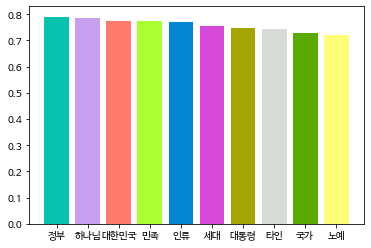

In [22]:
bargraph = model.wv.most_similar(positive=['국민'],topn=10)
showGraph(bargraph)
plt.show()

## 사전학습 가중치로 비교

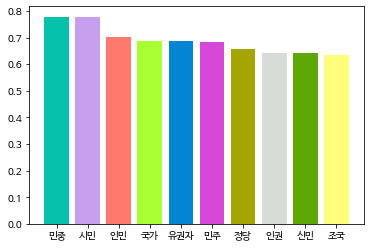

In [23]:
# 모델 불러오기
model_filename = '../data/word2vec_ko.model'
model = word2vec.Word2Vec.load(model_filename)

# 유사도 구하기
# 국민이라는 단어와 유사도가 높은 단어 10개를 리스트로 반환
bargraph = model.wv.most_similar(positive=['국민'],topn=10)
showGraph(bargraph)
plt.show()

# 사전학습 가중치 활용

In [24]:
w2v = word2vec.Word2Vec.load(model_filename)

In [25]:
vocab_size = 302960  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,),weights=[w2v.wv.vectors]))
model_gru.add(tf.keras.layers.GRU(128, return_sequences=True))
model_gru.add(tf.keras.layers.Dense(32, activation='relu'))
model_gru.add(tf.keras.layers.GRU(128, return_sequences=True))
model_gru.add(tf.keras.layers.Dense(32, activation='relu'))
model_gru.add(tf.keras.layers.GRU(128))
model_gru.add(tf.keras.layers.Dense(32, activation='relu'))
model_gru.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         30296000  
_________________________________________________________________
gru (GRU)                    (None, None, 128)         88320     
_________________________________________________________________
dense (Dense)                (None, None, 32)          4128      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         62208     
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)          4128      
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               62208     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

In [26]:
model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_gru.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/5
264/264 [==============================] - 16s 40ms/step - loss: 0.4774 - accuracy: 0.7598 - val_loss: 0.4152 - val_accuracy: 0.8039
Epoch 2/5
264/264 [==============================] - 10s 36ms/step - loss: 0.3605 - accuracy: 0.8387 - val_loss: 0.3669 - val_accuracy: 0.8381
Epoch 3/5
264/264 [==============================] - 10s 36ms/step - loss: 0.3164 - accuracy: 0.8627 - val_loss: 0.3436 - val_accuracy: 0.8501
Epoch 4/5
264/264 [==============================] - 10s 37ms/step - loss: 0.2830 - accuracy: 0.8809 - val_loss: 0.3447 - val_accuracy: 0.8495
Epoch 5/5
264/264 [==============================] - 10s 37ms/step - loss: 0.2516 - accuracy: 0.8969 - val_loss: 0.3364 - val_accuracy: 0.8556
